#Data Preparation

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10



(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.reshape(-1, 32,32,3) # 50,000 pic, ensure the right shape

# numpy.reshape(-1,32,32,3) 
# the first parameter = -1: we don't know the number of data (50000 in this case)
# 32,32,3 means 32x32 pixels 3 RGB channels

X_test = X_test.reshape(-1, 32,32,3) # 10,000 pic (again, -1 allow us to not care about the number of the data)

print("Dimension of train set: ", X_train.shape)
print("Dimension of test set: ", X_test.shape)

y_train = tf.keras.utils.to_categorical(y_train, 10) # one hot-encode format, 50,000 labels, 10 categories
y_test = tf.keras.utils.to_categorical(y_test, 10) # one hot-encode format, 10,000 labels, 10 categories

170508288/170498071 [==============================] - 12s 0us/step
Dimension of train set:  (50000, 32, 32, 3)
Dimension of test set:  (10000, 32, 32, 3)


# Data Exploration
Explore the data to see what X_train and y_train are like

Cifar10 Dataset Description: https://www.cs.toronto.edu/~kriz/cifar.html

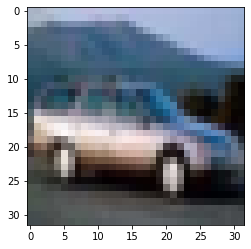

In [ ]:
import matplotlib.pyplot as plt
# plt.imshow show numpyarray data as image if it is valid
# X_train[4] select the 5th data entry
plt.imshow(X_train[4]) 

In [ ]:
print("Output of y_train ", y_train[4]) 


Output of y_train  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
classlist=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # Based on the data description
print("Class of data: ", classlist[np.argmax(y_train[4])])

Class of data:  automobile


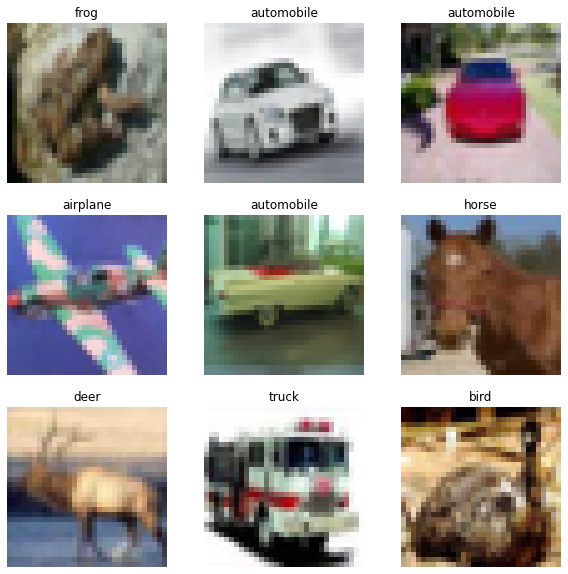

In [ ]:
## Show more photo
plt.figure(figsize = (10,10))  # Set figure size
for i in range(9): 
  a = np.random.randint(0,50000) # Random a
  ax = plt.subplot(3,3,i+1) # Create 3x3 subplots, i go from 1-> 9th subplot
  plt.imshow(X_train[a]) # Show images of X_train at "a" entries
  plt.title(classlist[np.argmax(y_train[a])]) #Show the corresponding labels
  plt.axis("off")

#Data Augmentation

## Visualization

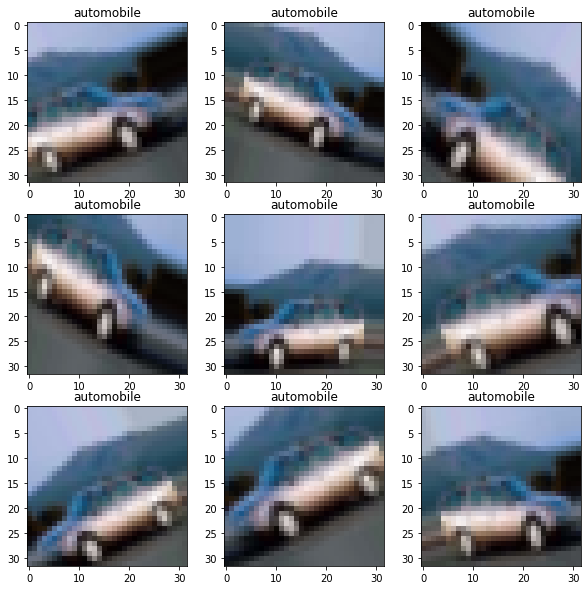

In [ ]:
#### NO SCALING BY /255.0 because we want to view the image. If we scale to [0,1] the image will be all black
from tensorflow.keras.preprocessing.image import ImageDataGenerator

demoGenerator = ImageDataGenerator(rotation_range=40, # Rotate image at random angle within 40
                                  width_shift_range=0.2, # Shift along width
                                  height_shift_range=0.2, # Shift along height
                                  shear_range=0.2, # Sheer the image
                                  zoom_range=0.2, # Zoom
                                  horizontal_flip=True #Flip horizontally
                                  )
generate = demoGenerator.flow(X_train[4].reshape(1,32,32,3), y_train[4].reshape(1,10))  # Flow 1 image [4] above
# Generate is an iterable object

fig = plt.figure(figsize = (10,10))
for i in range(9):
  plt.subplot(3,3,i+1)   # 3x3 subplot and go through them
  batch = generate.next() # go to the next iteratable object
	# convert to unsigned integers for viewing
  image = batch[0].astype('uint8')    # batch[0] is the X value
  plt.title(classlist[np.argmax(batch[1][0])]) # batch [1] is the y value
  plt.imshow(image[0])

## Implementing the Data Generator


We normalize the inputs to between 0 to 1.0 to:<br>
1. Prevents instability during training of NN<br>
2. Faster convergence of training in NN<br>


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalize the data as usual to have inputs (0 to 1.0)
                                  rotation_range=40, # Rotate image at random angle within 40
                                  width_shift_range=0.2, # Shift along width
                                  height_shift_range=0.2, # Shift along height
                                  shear_range=0.2, # Sheer the image
                                  zoom_range=0.2, # Zoom
                                  horizontal_flip=True #Flip horizontally
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize

In [ ]:
'''
ImageDataGenerator.flow(
    x,
    y=None,
    batch_size=32,
    shuffle=True,
    sample_weight=None,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
)
'''

train_generator = train_datagen.flow(X_train, y_train, batch_size=100) # train_datagen is an "Object". We "flow" X_train, y_train in to get an iterator
test_generator = test_datagen.flow(X_test, y_test, batch_size=100)

#Setup Base Model

In [ ]:
from tensorflow.keras.models import Sequential # The function to stack the layers Sequentially
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense ## Different type of layers
from tensorflow.keras.applications import VGG16 ## Base Model

In [ ]:
# input_shape: optional - only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3). 
# If include_top is False, shape can be other than 224 x 224

base_model = VGG16(weights='imagenet',include_top=False,input_shape=(32,32,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary() ## Take a look at VGG16 Model

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

#Freeze and Unfreeze Layers

In [ ]:
#
# We freeze the training of all the layers in base_model
#
for layer in base_model.layers: ## All layers
  layer.trainable = False

for layer in base_model.layers[-4:]: ## The last 4 layers
  layer.trainable = True

for layer in base_model.layers: 
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


## Add our own layers on top of the base

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten()) #turn all the output feature maps into a single dense layer so as to connect to the Fully Connected layer
model.add(Dense(1024,activation='relu'))
model.add(Dense(10,activation='softmax')) #10 categories in CIFAR10

In [ ]:
model.summary() # After VGG, we can see the layers that we defined

# output = Weight x input + Biases

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 15,250,250
Trainable params: 7,614,986
Non-trainable params: 7,635,264
_________________________________________________________________


### Recall how the layers calculate

Output = Weight x Input + Biases

**From Flatten to Dense**


512 input -> 1024 output => 512*1024 = 524288 Weights


1024 Biases


Parameters to train = Weight + Biases = 524288 + 1024 = 525312

#Compile & Fit

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-5),metrics=['accuracy']) ## Setup model

# Loss
# 

In [ ]:

#steps per epoch means number of batches used per epoch. It is 
#the number of batch iterations before a training epoch is considered finished. 
#
#by right, we should have: steps_per_epoch=len(trainX) // batch_size
#
#Training:
# steps_per_epoch=500 -> 500 batches per epoch
# batch size=100 -> 50000 samples per epoch
#
#Validation/Testing:
# validation_steps=100 -> 100 batches per epoch
# batch size=100 -> 10000 samples per epoch
# 
#Keep in mind that the data generator is meant to loop infinitely.
#Since the function is intended to loop infinitely, tf has no ability to determine when one epoch starts and a new epoch begins.
#So, we compute the steps_per_epoch value as the total number of training data points divided by the batch size. 
#Once tf hits this step count it knows that it’s a new epoch.
#
#validation_steps similar to steps_per_epoch but on the validation data set instead on the training data.
# 
history = model.fit(train_generator,epochs=10,steps_per_epoch=500,
                    validation_data=test_generator,validation_steps=100)

Epoch 1/10
500/500 [==============================] - 78s 97ms/step - loss: 1.6554 - accuracy: 0.4253 - val_loss: 1.2738 - val_accuracy: 0.5552
Epoch 2/10
500/500 [==============================] - 48s 96ms/step - loss: 1.3377 - accuracy: 0.5291 - val_loss: 1.1756 - val_accuracy: 0.5830
Epoch 3/10
500/500 [==============================] - 48s 96ms/step - loss: 1.2462 - accuracy: 0.5627 - val_loss: 1.1289 - val_accuracy: 0.5995
Epoch 4/10
500/500 [==============================] - 48s 96ms/step - loss: 1.1917 - accuracy: 0.5800 - val_loss: 1.0275 - val_accuracy: 0.6360
Epoch 5/10
500/500 [==============================] - 48s 95ms/step - loss: 1.1559 - accuracy: 0.5920 - val_loss: 1.0125 - val_accuracy: 0.6405
Epoch 6/10
500/500 [==============================] - 47s 94ms/step - loss: 1.1210 - accuracy: 0.6065 - val_loss: 0.9608 - val_accuracy: 0.6616
Epoch 7/10
500/500 [==============================] - 48s 96ms/step - loss: 1.1073 - accuracy: 0.6101 - val_loss: 0.9752 - val_accuracy:

#Evaluate

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(10)

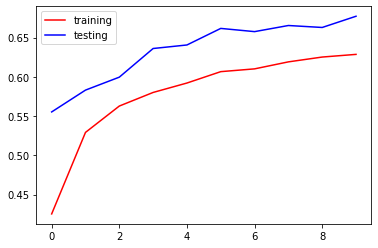

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs,acc,'r',label='training')
plt.plot(epochs,val_acc,'b',label='testing')
plt.legend()

#Let's do some predictions!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# You can load a model and its weights with load_model and make prediction with predict method
#

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

# img = load_img(path="/content/drive/My Drive/MLDA Workshop - Intro to DL in CV/Picture/img_leopard.jfif", target_size=(32,32))
# img = load_img(path="/content/drive/My Drive/MLDA Workshop - Intro to DL in CV/Picture/img_plane.webp", target_size=(32,32))
img = load_img(path="/content/drive/My Drive/MLDA Workshop - Intro to DL in CV/Picture/cat.jpg", target_size=(32,32))

imgArray = img_to_array(img) #convert to numpy array
print (imgArray.shape)
imgInput = imgArray.reshape(1,32,32,3).astype('float32')/255.0

predictions = model.predict(imgInput)
#predicted_class = model.predict_classes(imgInput) to be deprecated after 2021-1-1

print(predictions)
for i,x in enumerate(predictions[0]):
  print(i, "%.4f" % x)

predicted=np.argmax(predictions[0])


print(classlist[predicted])

(32, 32, 3)
[[0.00628341 0.00459144 0.01456487 0.25404656 0.03080701 0.55529165
  0.06011763 0.03674453 0.02361439 0.01393848]]
0 0.0063
1 0.0046
2 0.0146
3 0.2540
4 0.0308
5 0.5553
6 0.0601
7 0.0367
8 0.0236
9 0.0139
dog
